In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

array([[ 54, 192, 194, ..., 198, 199, 155],
       [ 54, 187, 186, ..., 217, 218, 190],
       [ 68, 174, 178, ..., 168, 183, 206],
       ...,
       [ 87, 215, 210, ..., 146, 193, 207],
       [ 66, 213, 211, ..., 157, 166, 176],
       [ 88,  88,  87, ..., 104, 112, 111]], dtype=uint8)
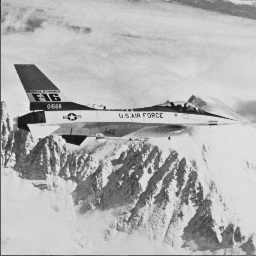

In [12]:
img = cv2.imread('airplane.png', cv2.IMREAD_GRAYSCALE)
img

In [13]:
def Gaussian_kernel(pixel1,pixel2, omega):
  return np.exp(-((pixel1[0]-pixel2[0])**2+(pixel1[1]-pixel2[1])**2)/(2*omega**2))

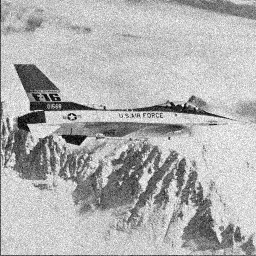

In [14]:
mean = 0
var = 225
sigma = var**0.5
noisy_img = img.copy()
tester_img = img.copy()
noise = np.random.normal(mean,sigma,(img.shape[0],img.shape[1]))

noisy_img = img + noise

noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
cv2_imshow(noisy_img)

In [15]:
def extract_p_time_p_square(tuple_point, p, omega, img, noisy_img):
  """
  Extracts p time p square around the point given by the tuple and computes the Gaussian kernel matrix that is p^2 x p^2.

  Args:
    tuple_point: A tuple representing the coordinates (x, y) of the point.
    p: The size of the square (p x p).
    omega: The value used for calculating the Gaussian kernel.

  Returns:
    - A list of tuples representing the coordinates within the p x p square
    around the given point
    - The p^2 x p^2 Gaussian kernel matrix (if the square is fully contained in the image)
    - The pixel_strength list (in the same order as the extracted pixels)
  """
  x, y = tuple_point
  extracted_points = []
  pixel_strengths =[]


  for i in range(x - p // 2, x + p // 2 + 1):
    for j in range(y - p // 2, y + p // 2 + 1):
      if 0 <= i < img.shape[0] and 0 <= j < img.shape[1]:
        extracted_points.append((i, j))
        pixel_strengths.append(noisy_img[i,j])

  K=np.zeros((len(extracted_points),len(extracted_points)))
  for i in range(len(extracted_points)):
    for j in range(len(extracted_points)):
      K[i,j]=Gaussian_kernel(extracted_points[i],extracted_points[j],omega)
  return extracted_points, K, pixel_strengths


Best l: 0.05
Best omega: 2
Best SSIM: 0.7598567580296556


array([[ 81, 143, 176, ..., 182, 174, 151],
       [ 91, 156, 188, ..., 197, 191, 172],
       [ 95, 155, 184, ..., 192, 186, 169],
       ...,
       [120, 181, 208, ..., 173, 182, 175],
       [105, 154, 175, ..., 156, 160, 152],
       [ 73, 104, 115, ..., 115, 115, 107]], dtype=uint8)
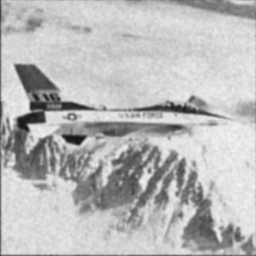

In [17]:
p_size=5
def optimize_hyperparameters(img, noisy_img, l_values, omega_values):
    best_l = None
    best_omega = None
    best_ssim = -1
    for l in l_values:
        for omega_value in omega_values:
            tester_img = img.copy()

            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    extracted_points, K, pixel_strenths = extract_p_time_p_square((i,j), p_size, omega_value, img, noisy_img)
                    alpha = np.matmul(np.linalg.inv(np.add(K,l*len(extracted_points)*np.identity(len(extracted_points)))),pixel_strenths)
                    kernel = []
                    for point in extracted_points:
                        kernel.append(Gaussian_kernel((i,j),point,omega_value))
                    tester_img[i,j] = np.matmul(kernel,alpha)


            current_ssim = ssim(img, tester_img, data_range=img.max() - img.min())

            if current_ssim > best_ssim:
                best_ssim = current_ssim
                best_l = l
                best_omega = omega_value
                tester_img2 = tester_img.copy()

    return tester_img2, best_l, best_omega, best_ssim


#values
l_values = [0.01, 0.05, 0.1]
omega_values = [1, 2, 3.5, 5]

tester_img2, best_l, best_omega, best_ssim = optimize_hyperparameters(img, noisy_img, l_values, omega_values)

print(f"Best l: {best_l}")
print(f"Best omega: {best_omega}")
print(f"Best SSIM: {best_ssim}")
tester_img2

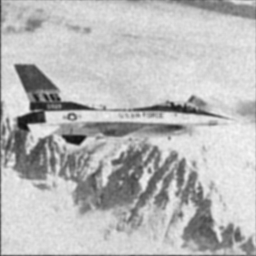

In [7]:
p_size=5
l = 0.05
omega_value = 2
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
            extracted_points, K, pixel_strenths = extract_p_time_p_square((i,j), p_size, omega_value, img, noisy_img)
            alpha = np.matmul(np.linalg.inv(np.add(K,l*len(extracted_points)*np.identity(len(extracted_points)))),pixel_strenths)
            kernel = []
            for point in extracted_points:
                kernel.append(Gaussian_kernel((i,j),point,omega_value))
            tester_img[i,j] = np.matmul(kernel,alpha)


cv2_imshow(tester_img)

In [18]:
ssim_value = ssim(tester_img2, img, data_range=img.max() - img.min())
print(f"SSIM value is {ssim_value}")

SSIM value is 0.7598567580296556


In [19]:
psnr_value = psnr(tester_img2, img, data_range=img.max() - img.min())
print(f"PSNR value is {psnr_value}")

PSNR value is 23.006075614427715


In [20]:
ssim_original = ssim(noisy_img, img, data_range=noisy_img.max() - noisy_img.min())
print(f"SSIM value of original image and the noisy_img is {ssim_original}")


SSIM value of original image and the noisy_img is 0.5468123661964229
